In [1]:
import numpy as np 
import pandas as pd

In [2]:
air = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')

In [3]:
# EDA - look at the shape of the dataset
air.shape

(79023, 76)

In [4]:
air.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [5]:
# Understand data types
pd.set_option('display.max_rows', None)
air.dtypes

ID_LAT_LON_YEAR_WEEK                                         object
latitude                                                    float64
longitude                                                   float64
year                                                          int64
week_no                                                       int64
SulphurDioxide_SO2_column_number_density                    float64
SulphurDioxide_SO2_column_number_density_amf                float64
SulphurDioxide_SO2_slant_column_number_density              float64
SulphurDioxide_cloud_fraction                               float64
SulphurDioxide_sensor_azimuth_angle                         float64
SulphurDioxide_sensor_zenith_angle                          float64
SulphurDioxide_solar_azimuth_angle                          float64
SulphurDioxide_solar_zenith_angle                           float64
SulphurDioxide_SO2_column_number_density_15km               float64
CarbonMonoxide_CO_column_number_density         

In [6]:
# Understand the target variable
air['emission'].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

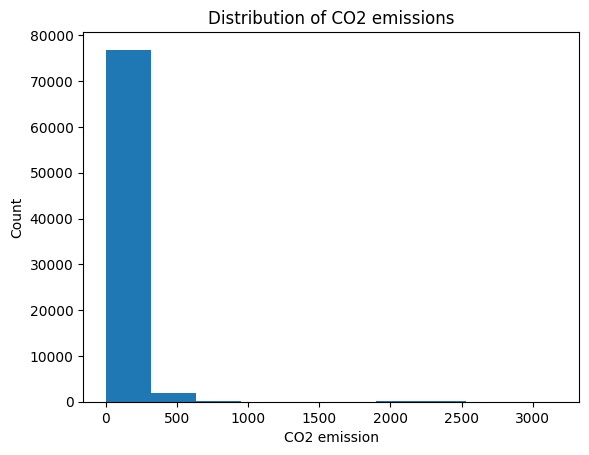

In [7]:
# Visualize the target variable
import matplotlib
from matplotlib import pylab as plt
air['emission'].plot.hist()
plt.xlabel('CO2 emission')
plt.ylabel('Count')
plt.title('Distribution of CO2 emissions')
plt.show()

From the above plot, we can see that the CO2 emission is skewed and follows a long tail distribution

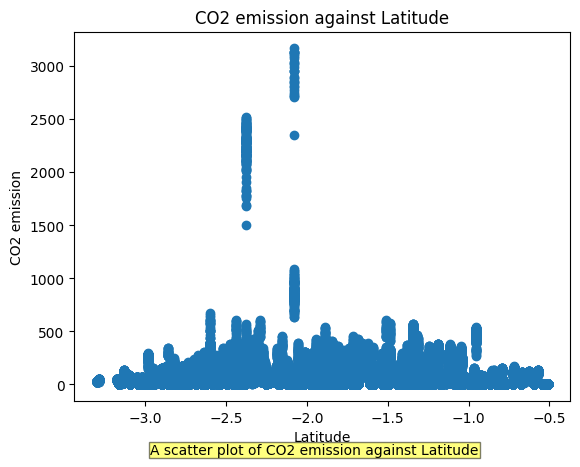

In [8]:
# CO2 against latitude
plt.scatter(air['latitude'], air['emission'])
plt.title('CO2 emission against Latitude')
plt.xlabel('Latitude')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against Latitude", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

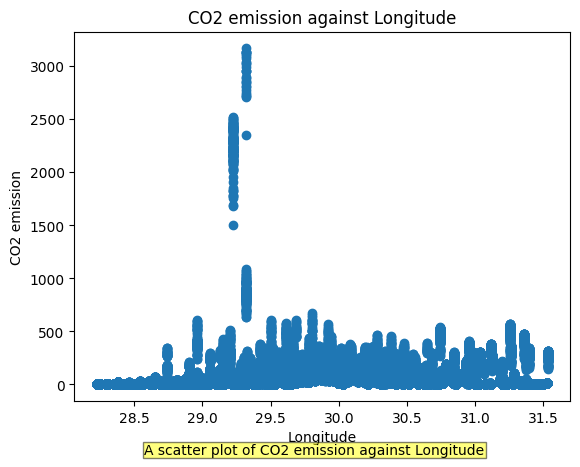

In [9]:
# CO2 against latitude
plt.scatter(air['longitude'], air['emission'])
plt.title('CO2 emission against Longitude')
plt.xlabel('Longitude')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against Longitude", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

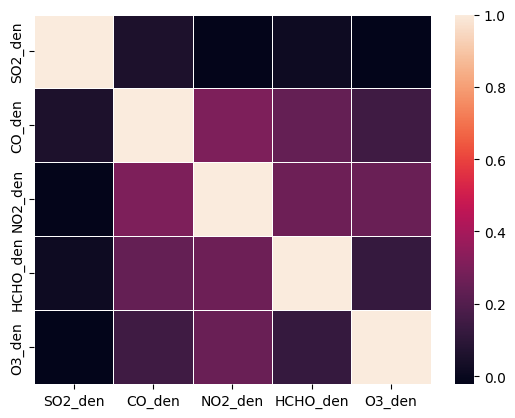

In [10]:
# Heatmap to understand correlation between density of gases
# TODO: rename gas to shorter names - SO2_density, CO_density, NO2_density, HCHO_density, O3_density
import seaborn as sns

#rename columns for better heatmap display
air.rename(columns = {'SulphurDioxide_SO2_column_number_density':'SO2_den', 'CarbonMonoxide_CO_column_number_density': 'CO_den', 'NitrogenDioxide_NO2_column_number_density':'NO2_den', 'Formaldehyde_tropospheric_HCHO_column_number_density':'HCHO_den', 'Ozone_O3_column_number_density': 'O3_den'}, inplace = True)
density = air[['SO2_den', 'CO_den', 'NO2_den', 'HCHO_den', 'O3_den']].corr()
ax = sns.heatmap(density, linewidth=0.5)

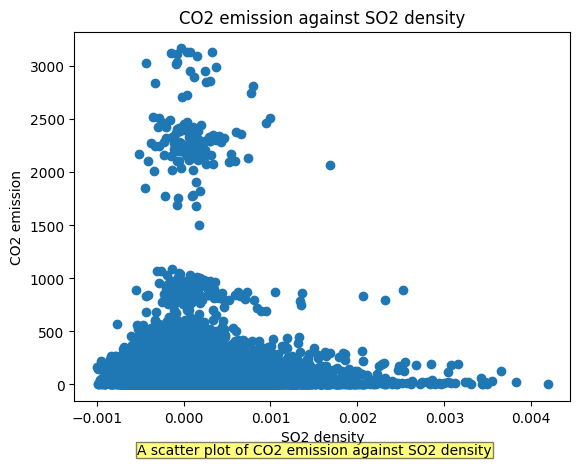

In [11]:
# CO2 against SO2
plt.scatter(air['SO2_den'], air['emission'])
plt.title('CO2 emission against SO2 density')
plt.xlabel('SO2 density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against SO2 density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

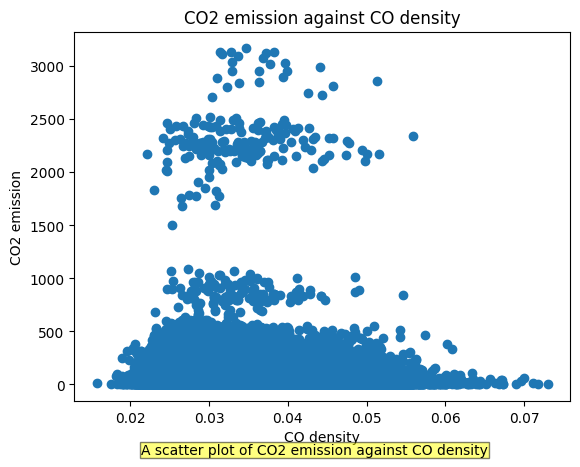

In [12]:
# CO2 against CO
plt.scatter(air['CO_den'], air['emission'])
plt.title('CO2 emission against CO density')
plt.xlabel('CO density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against CO density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

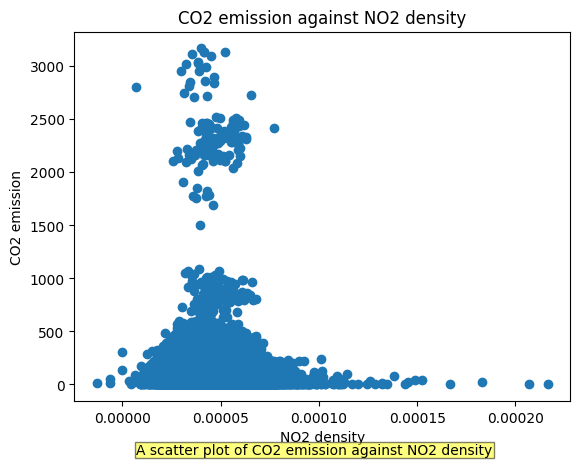

In [13]:
# CO2 against NO2
plt.scatter(air['NO2_den'], air['emission'])
plt.title('CO2 emission against NO2 density')
plt.xlabel('NO2 density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against NO2 density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

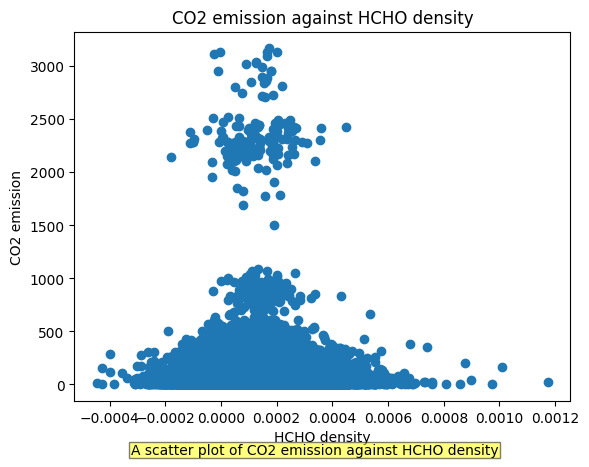

In [14]:
# CO2 against HCHO
plt.scatter(air['HCHO_den'], air['emission'])
plt.title('CO2 emission against HCHO density')
plt.xlabel('HCHO density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against HCHO density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

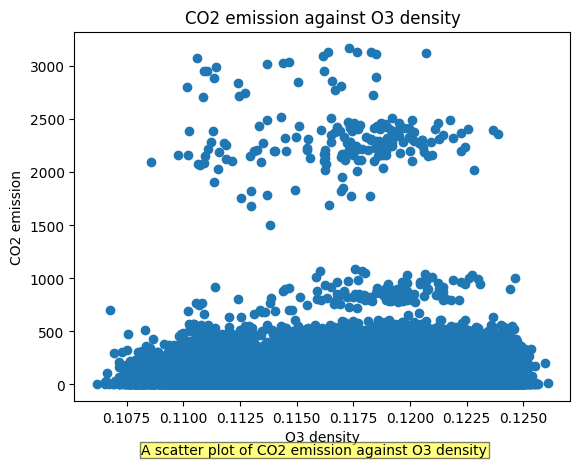

In [15]:
# CO2 against O3
plt.scatter(air['O3_den'], air['emission'])
plt.title('CO2 emission against O3 density')
plt.xlabel('O3 density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against O3 density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

In [16]:
# Splitting and preprocessing data
# Separate features and target variable
air_features = air.iloc[:, 0:-1]
emission = air.iloc[:, -1]

In [17]:
from sklearn.model_selection import train_test_split
# As the dataset already splitted the data into train & test, only splitting between train and validation sets are necessary
air_features_train, air_features_val, emission_train, emission_val = train_test_split(air_features,emission,train_size=0.75)

In [18]:
# checking the shape of training set
# should be 75% of original train set with 1 less column (target)
air_features_train.shape

(59267, 75)

In [19]:
# checking the shape of validation set
# should be 25% of original train set with 1 less column (target)
air_features_val.shape

(19756, 75)

In [20]:
# check for missing values
air.isna().sum()

ID_LAT_LON_YEAR_WEEK                                            0
latitude                                                        0
longitude                                                       0
year                                                            0
week_no                                                         0
SO2_den                                                     14609
SulphurDioxide_SO2_column_number_density_amf                14609
SulphurDioxide_SO2_slant_column_number_density              14609
SulphurDioxide_cloud_fraction                               14609
SulphurDioxide_sensor_azimuth_angle                         14609
SulphurDioxide_sensor_zenith_angle                          14609
SulphurDioxide_solar_azimuth_angle                          14609
SulphurDioxide_solar_zenith_angle                           14609
SulphurDioxide_SO2_column_number_density_15km               14609
CO_den                                                       2122
CarbonMono

In [21]:
# check percentage of missing values
100*air.isna().sum()/len(air)

ID_LAT_LON_YEAR_WEEK                                         0.000000
latitude                                                     0.000000
longitude                                                    0.000000
year                                                         0.000000
week_no                                                      0.000000
SO2_den                                                     18.487023
SulphurDioxide_SO2_column_number_density_amf                18.487023
SulphurDioxide_SO2_slant_column_number_density              18.487023
SulphurDioxide_cloud_fraction                               18.487023
SulphurDioxide_sensor_azimuth_angle                         18.487023
SulphurDioxide_sensor_zenith_angle                          18.487023
SulphurDioxide_solar_azimuth_angle                          18.487023
SulphurDioxide_solar_zenith_angle                           18.487023
SulphurDioxide_SO2_column_number_density_15km               18.487023
CO_den              

In [22]:
# Preprocessing the training data
# As most of the data are continuous variables, Standard Scaler is suitable

# avoid columns that are categorical (year, week_no, ID)
cat_col_train = air_features_train[['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no']]
std_col_train = air_features_train.drop(['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no'], axis=1)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
air_features_train_std = scaler.fit_transform(std_col_train)

In [24]:
air_features_processed_train = pd.DataFrame(np.concatenate([cat_col_train, air_features_train_std], axis=1), columns=air_features_train.columns)
air_features_processed_train.rename(columns={'latitude': 'year', 'longitude': 'week_no', 'year': 'latitude', 'week_no': 'longitude'}, inplace=True)
air_features_processed_train.head()

,ID_LAT_LON_YEAR_WEEK,year,week_no,latitude,longitude,SO2_den,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-2.689_28.811_2019_42,2019,42,-1.15062,-1.321299,-0.748623,1.266044,-0.983436,1.83672,1.243488,...,-0.233396,0.227792,-0.166386,0.182121,0.113297,-0.836926,1.841527,-0.60702,-0.685372,-0.871828
1,ID_-1.170_29.330_2019_50,2019,50,1.036504,-0.681063,-0.158637,0.123969,-0.106801,-0.908975,0.36698,...,-1.042173,1.061151,-1.03714,1.057904,0.527349,1.402585,-1.776731,0.656137,-1.220033,1.567964
2,ID_-0.853_30.647_2021_18,2021,18,1.492935,0.94358,0.077192,0.393286,0.121408,0.733661,1.274784,...,0.13337,-0.079295,0.196818,-0.1406,-0.421998,0.874421,-0.056108,-0.721806,0.936335,0.313613
3,ID_-2.133_30.467_2020_42,2020,42,-0.350066,0.721533,-0.994625,0.875212,-1.196537,1.500768,-1.137848,...,0.977341,-0.677128,0.957645,-0.675101,-0.700618,-1.104184,-0.26148,0.058686,-0.666175,-0.360631
4,ID_-2.082_29.218_2019_06,2019,6,-0.276634,-0.819226,-0.742537,-0.692883,-0.478906,0.337534,-0.512966,...,0.237374,-0.90357,0.079081,-0.849492,-0.889806,-1.797238,-1.473284,-1.77481,-0.787037,-0.515343


In [25]:
# Preprocessing the validation data

cat_col_val = air_features_val[['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no']]
std_col_val = air_features_val.drop(['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no'], axis=1)
air_features_val_std = scaler.fit_transform(std_col_val)

In [26]:
air_features_processed_val = pd.DataFrame(np.concatenate([cat_col_val, air_features_val_std], axis=1), columns=air_features_val.columns)
air_features_processed_val.rename(columns={'latitude': 'year', 'longitude': 'week_no', 'year': 'latitude', 'week_no': 'longitude'}, inplace=True)
air_features_processed_val.head()

,ID_LAT_LON_YEAR_WEEK,year,week_no,latitude,longitude,SO2_den,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-1.510_30.190_2021_11,2021,11,0.553884,0.389942,-0.606219,0.048621,-0.667665,1.074421,-0.06701,...,-0.716716,0.94645,-0.798499,0.998954,0.411443,-0.166619,-0.790883,-0.690673,-0.087526,-1.385436
1,ID_-1.861_30.939_2020_36,2020,36,0.048485,1.315166,-1.102156,0.445833,-0.94097,1.499374,-0.092555,...,-0.328064,0.266648,-0.295233,0.222364,0.275625,-1.062377,-0.075352,0.918122,0.379436,-0.665528
2,ID_-2.815_30.285_2021_01,2021,1,-1.325163,0.507293,-1.814758,-0.199238,-1.810684,0.722147,1.246252,...,-0.428967,0.527747,-0.406802,0.521614,0.000671,0.529643,-0.49685,-0.004936,-1.344718,0.163428
3,ID_-1.225_30.975_2021_34,2021,34,0.964251,1.359636,-0.51376,0.514359,-0.636049,0.226128,-0.685609,...,0.401329,-0.32483,0.474782,-0.394509,-0.821532,-0.729757,-1.519373,-2.552264,0.606021,-0.215133
4,ID_-1.065_31.035_2021_26,2021,26,1.194632,1.433753,NaN,NaN,NaN,NaN,NaN,...,0.951319,-0.800659,1.080206,-0.899349,-0.659348,-0.660645,-0.076362,0.898269,1.291515,1.021938


In [27]:
test = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')
test.rename(columns = {'SulphurDioxide_SO2_column_number_density':'SO2_den', 'CarbonMonoxide_CO_column_number_density': 'CO_den', 'NitrogenDioxide_NO2_column_number_density':'NO2_den', 'Formaldehyde_tropospheric_HCHO_column_number_density':'HCHO_den', 'Ozone_O3_column_number_density': 'O3_den'}, inplace = True)

In [28]:
# Preprocessing the test data
cat_col_test = test[['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no']]
std_col_test = test.drop(['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no'], axis=1)
air_features_test_std = scaler.fit_transform(std_col_test)

In [29]:
air_features_processed_test = pd.DataFrame(np.concatenate([cat_col_test, air_features_test_std], axis=1), columns=test.columns)
air_features_processed_test.rename(columns={'latitude': 'year', 'longitude': 'week_no', 'year': 'latitude', 'week_no': 'longitude'}, inplace=True)
air_features_processed_test.head()

,ID_LAT_LON_YEAR_WEEK,year,week_no,latitude,longitude,SO2_den,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,2022,0,1.988534,-0.728253,NaN,NaN,NaN,NaN,NaN,...,-1.919882,1.892377,-1.955373,1.903406,-0.837675,-0.327072,-2.690528,-1.014707,-1.419048,1.303318
1,ID_-0.510_29.290_2022_01,2022,1,1.988534,-0.728253,1.891097,-0.603464,1.805421,-1.743214,0.996944,...,-0.442716,0.451547,-0.437662,0.439897,-0.551536,0.795929,-0.466502,0.369455,-1.575572,0.680922
2,ID_-0.510_29.290_2022_02,2022,2,1.988534,-0.728253,0.628419,-1.115595,0.569995,-0.743127,-0.764798,...,-2.142789,2.262286,-2.178836,2.279137,-0.608169,0.238373,1.757338,0.931335,-1.747982,-0.279259
3,ID_-0.510_29.290_2022_03,2022,3,1.988534,-0.728253,1.438202,-0.569231,1.378622,0.773957,0.936335,...,-0.169501,0.118493,-0.138814,0.101601,-0.525786,1.043937,-0.273342,0.32777,-1.474546,0.364326
4,ID_-0.510_29.290_2022_04,2022,4,1.988534,-0.728253,-1.412903,-1.26187,-1.136992,0.81558,0.996224,...,-0.672244,0.720874,-0.658643,0.713463,-0.419832,0.605039,0.095946,-1.583029,-1.48778,-0.384195
